# Data Preprocessing

In [27]:
# Phase 1 — Step 1: Load data & inspect
import pandas as pd
import numpy as np
import re

Cell 1 — Load data & quick inspection

In [63]:

PATH = r"C:\Users\tarun\Downloads\dataset.csv\dataset.csv"

df = pd.read_csv(PATH)

print("Shape (rows, cols):", df.shape)
print("\nColumns:", list(df.columns))
print("\nDtypes:")
print(df.dtypes)

print("\nSample rows:")
display(df.head(5))

print("\nNull counts (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

Shape (rows, cols): (114000, 21)

Columns: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Dtypes:
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

Sample rows:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic



Null counts (top 10):
artists         1
track_name      1
album_name      1
Unnamed: 0      0
track_id        0
popularity      0
duration_ms     0
explicit        0
danceability    0
energy          0
dtype: int64


Cell 2 — Drop useless columns

In [6]:
# Phase 1 — Step 2: Handle useless columns (drop auto-generated index)
cols_before = set(df.columns)
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
dropped = cols_before - set(df.columns)

print("Dropped columns:", dropped if dropped else "None")
print("New shape:", df.shape)


Dropped columns: {'Unnamed: 0'}
New shape: (114000, 20)


Cell 3 — Fix data types (numeric & categorical)

In [7]:
# Phase 1 — Step 3: Fix data types

# Columns that should be numeric for this dataset (only those that exist will be coerced)
numeric_should_be = [
    "popularity","duration_ms","danceability","energy","key","loudness",
    "speechiness","acousticness","instrumentalness","liveness","valence",
    "tempo","time_signature","mode"
]
numeric_present = [c for c in numeric_should_be if c in df.columns]

# Coerce to numeric (invalid -> NaN to be caught in missingness step)
for c in numeric_present:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Categorical conversions (only if present)
if "track_genre" in df.columns:
    df["track_genre"] = df["track_genre"].astype("category")

# Ensure boolean for 'explicit' if present
if "explicit" in df.columns:
    # If explicit already bool, this keeps it; if it's 0/1 or 'True'/'False', coerce to bool safely
    if df["explicit"].dtype != bool:
        # Try common patterns; fallback to bool cast
        mapping = {"true": True, "false": False, "1": True, "0": False}
        df["explicit"] = (
            df["explicit"]
            .astype(str).str.lower().map(mapping)
            .fillna(df["explicit"].astype(bool))
        )
    df["explicit"] = df["explicit"].astype(bool)

print("Dtype summary after coercion:")
print(df.dtypes)


Dtype summary after coercion:
track_id              object
artists               object
album_name            object
track_name            object
popularity             int64
duration_ms            int64
explicit                bool
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature         int64
track_genre         category
dtype: object


Cell 4 — Handle missing values

In [8]:
# Phase 1 — Step 4: Handle missing values
# Fill minimal text missingness with "Unknown"
fill_map = {}
for col in ["artists", "album_name", "track_name"]:
    if col in df.columns:
        fill_map[col] = "Unknown"

missing_before = df.isna().sum().sum()
df.fillna(fill_map, inplace=True)
missing_after_fill_text = df.isna().sum().sum()

print(f"Total missing before: {missing_before}")
print(f"Total missing after text fill: {missing_after_fill_text}")

# (Optional) If numeric coercion created NaNs, we do NOT impute here in Phase 1.
# We'll handle numeric imputation inside the modeling/processing pipeline later.
# For visibility, show any remaining missingness:
print("\nRemaining nulls by column (nonzero only):")
rem = df.isna().sum()
print(rem[rem > 0].sort_values(ascending=False))


Total missing before: 3
Total missing after text fill: 0

Remaining nulls by column (nonzero only):
Series([], dtype: int64)


Cell 5 — Handle duplicates (exact + semantic)

In [9]:
# Phase 1 — Step 5: Handle duplicates

# 5.1 Exact duplicate rows
rows_before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print("Removed exact duplicate rows:", rows_before - len(df))

# 5.2 Semantic duplicates: prefer unique track_id; fallback to (track_name, artists, duration)
# We keep the row with the highest 'popularity' when duplicates exist.

dup_id_count = df.duplicated(subset=["track_id"]).sum() if "track_id" in df.columns else 0
print("Potential duplicates by track_id:", dup_id_count)

# Build a semantic key only if the columns exist
sem_parts = []
if "track_name" in df.columns:
    sem_parts.append(df["track_name"].astype(str).str.lower().str.strip())
if "artists" in df.columns:
    sem_parts.append(df["artists"].astype(str).str.lower().str.strip())
if "duration_ms" in df.columns:
    sem_parts.append((df["duration_ms"] // 1000).astype(str))

if sem_parts:
    df["__sem_key__"] = " | ".join(sem_parts) if isinstance(sem_parts, str) else sem_parts[0]
    for part in sem_parts[1:]:
        df["__sem_key__"] = df["__sem_key__"] + " | " + part
else:
    df["__sem_key__"] = pd.NA  # no-op if not enough columns

# Sort by popularity desc if available, so we keep most popular among duplicates
sort_cols = ["popularity"] if "popularity" in df.columns else None
if sort_cols:
    df = df.sort_values(sort_cols, ascending=False)

# Drop dups by track_id first (if present), then by semantic key (if built)
before = len(df)
if "track_id" in df.columns:
    df = df.drop_duplicates(subset=["track_id"], keep="first")
after_track_id = before - len(df)

before2 = len(df)
if df["__sem_key__"].notna().any():
    df = df.drop_duplicates(subset=["__sem_key__"], keep="first")
after_sem = before2 - len(df)

# Cleanup helper column
df = df.drop(columns="__sem_key__", errors="ignore").reset_index(drop=True)

print(f"Removed by track_id: {after_track_id}")
print(f"Removed by semantic key: {after_sem}")
print("Final shape:", df.shape)


Removed exact duplicate rows: 450
Potential duplicates by track_id: 23809
Removed by track_id: 23809
Removed by semantic key: 7262
Final shape: (82479, 20)


Cell 6 — Sanity check after Phase 1

In [10]:
print("Final dtypes:")
print(df.dtypes)

print("\nAny remaining nulls?")
nulls = df.isna().sum()
print(nulls[nulls > 0].sort_values(ascending=False) if (nulls > 0).any() else "No remaining nulls in text columns we filled.")

print("\nPreview:")
display(df.head(5))


Final dtypes:
track_id              object
artists               object
album_name            object
track_name            object
popularity             int64
duration_ms            int64
explicit                bool
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature         int64
track_genre         category
dtype: object

Any remaining nulls?
No remaining nulls in text columns we filled.

Preview:


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.266,0.238,131.121,4,dance
1,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,False,0.621,0.782,2,-5.548,1,0.0440,0.01250,0.033000,0.230,0.550,128.033,4,hip-hop
2,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,False,0.835,0.679,7,-5.329,0,0.0364,0.58300,0.000002,0.218,0.850,124.980,4,latino
3,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'm Good (Blue),I'm Good (Blue),98,175238,True,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.371,0.304,128.040,4,edm
4,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Un Verano Sin Ti,Tití Me Preguntó,97,243716,False,0.650,0.715,5,-5.198,0,0.2530,0.09930,0.000291,0.126,0.187,106.672,4,reggaeton


# Data Cleaning

Cell 1 — Text cleaning (trim + standardized capitalization)

In [11]:
# Phase 2 — Step 1: Text cleaning
# - Trim whitespace
# - Title-case or sentence-case (choose what fits best; here: title-case)

text_cols = [c for c in ["track_name", "album_name", "artists"] if c in df.columns]

def clean_text(s: pd.Series, mode="title"):
    s = s.astype(str).str.strip()
    if mode == "title":
        s = s.str.title()
    elif mode == "lower":
        s = s.str.lower()
    elif mode == "upper":
        s = s.str.upper()
    return s

for c in text_cols:
    df[c] = clean_text(df[c], mode="title")

print("Cleaned text columns:", text_cols)
display(df[text_cols].head(5))


Cleaned text columns: ['track_name', 'album_name', 'artists']


,track_name,album_name,artists
0,Unholy (Feat. Kim Petras),Unholy (Feat. Kim Petras),Sam Smith;Kim Petras
1,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo
2,La Bachata,La Bachata,Manuel Turizo
3,I'M Good (Blue),I'M Good (Blue),David Guetta;Bebe Rexha
4,Tití Me Preguntó,Un Verano Sin Ti,Bad Bunny


Cell 2 — Outlier detection (summaries for key numeric columns)

In [12]:
# Phase 2 — Step 2: Outlier detection (non-destructive)

num_cols = [c for c in [
    "duration_ms", "tempo", "loudness", "danceability", "energy",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence"
] if c in df.columns]

summary = []
for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    summary.append({
        "column": c,
        "min": float(df[c].min()),
        "q1": float(q1),
        "median": float(df[c].median()),
        "q3": float(q3),
        "max": float(df[c].max()),
        "IQR": float(iqr),
        "lower_fence": float(low),
        "upper_fence": float(high),
        "pct_below": float((df[c] < low).mean()*100),
        "pct_above": float((df[c] > high).mean()*100),
    })

outlier_df = pd.DataFrame(summary).sort_values("pct_above", ascending=False)
display(outlier_df)


,column,min,q1,median,q3,max,IQR,lower_fence,upper_fence,pct_below,pct_above
7,instrumentalness,0.000,0.0000,0.000086,0.1450,1.000,0.1450,-0.21750,0.36250,0.000000,21.410298
5,speechiness,0.000,0.0360,0.049100,0.0866,0.965,0.0506,-0.03990,0.16250,0.000000,11.910911
8,liveness,0.000,0.0985,0.133000,0.2830,1.000,0.1845,-0.17825,0.55975,0.000000,7.960814
0,duration_ms,0.000,173889.5000,215295.000000,267244.5000,5237295.000,93355.0000,33857.00000,407277.00000,0.080020,4.555099
1,tempo,0.000,99.4340,122.028000,140.1215,243.372,40.6875,38.40275,201.15275,0.192776,0.351605
2,loudness,-49.531,-10.4680,-7.269000,-5.1430,4.532,5.3250,-18.45550,2.84450,5.590514,0.002425
4,energy,0.000,0.4540,0.678000,0.8560,1.000,0.4020,-0.14900,1.45900,0.000000,0.000000
3,danceability,0.000,0.4470,0.573000,0.6900,0.985,0.2430,0.08250,1.05450,0.486184,0.000000
6,acousticness,0.000,0.0160,0.191000,0.6300,0.996,0.6140,-0.90500,1.55100,0.000000,0.000000
9,valence,0.000,0.2430,0.450000,0.6780,0.995,0.4350,-0.40950,1.33050,0.000000,0.000000


In [17]:
# Phase 2 — Step 2b: Optional capping / transformation

def winsorize_series(s: pd.Series, lower=0.005, upper=0.995) -> pd.Series:
    lo, hi = s.quantile([lower, upper])
    return s.clip(lower=lo, upper=hi)

# ---- Strategy A: Winsorize a few skewed columns ----
# Uncomment to apply
for c in ["duration_ms", "tempo"]:
    if c in df.columns:
         df[c] = winsorize_series(df[c], lower=0.005, upper=0.995)

# ---- Strategy B: Log-transform skewed positive columns (creates new cols) ----
# Uncomment to apply
if "duration_ms" in df.columns:
     df["log_duration_ms"] = np.log1p(df["duration_ms"])
if "tempo" in df.columns and (df["tempo"] > 0).all():
     df["log_tempo"] = np.log1p(df["tempo"])

print("Optional outlier handling is ready")


Optional outlier handling is ready


Cell 4 — Encoding categorical variables (explicit → 0/1; genre categorical)

In [22]:
# Phase 2 — Step 3: Encode categorical variables

# explicit -> binary 0/1
if "explicit" in df.columns:
    # If already boolean this will convert to 0/1; if not, try to coerce
    if df["explicit"].dtype != bool:
        mapping = {"true": True, "false": False, "1": True, "0": False, "yes": True, "no": False}
        df["explicit"] = (
            df["explicit"].astype(str).str.lower().map(mapping)
            .fillna(df["explicit"].astype(bool))
        )
    df["explicit"] = df["explicit"].astype(int)

# track_genre -> category
if "track_genre" in df.columns:
    df["track_genre"] = df["track_genre"].astype("category")

print("Encoded 'explicit' to 0/1 (if present) and set 'track_genre' as categorical.")
print(df[["explicit"]].head() if "explicit" in df.columns else "No 'explicit' column found.")
print(df["track_genre"].cat.categories[:] if "track_genre" in df.columns else "No 'track_genre' column found.")


Encoded 'explicit' to 0/1 (if present) and set 'track_genre' as categorical.
   explicit
0         0
1         0
2         0
3         1
4         0
Index(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime',
       'black-metal', 'bluegrass', 'blues', 'brazil',
       ...
       'spanish', 'study', 'swedish', 'synth-pop', 'tango', 'techno', 'trance',
       'trip-hop', 'turkish', 'world-music'],
      dtype='object', length=114)


Cell 5 — Sanity checks (NaNs + numeric ranges)

In [23]:
# Phase 2 — Step 4: Sanity checks

# 4.1 Remaining NaNs?
nulls = df.isna().sum()
print("Columns with remaining NaNs:")
print(nulls[nulls > 0].sort_values(ascending=False) if (nulls > 0).any() else "None")

# 4.2 Expected ranges for 0–1 bounded features
bounded_01 = [c for c in ["danceability","energy","speechiness","acousticness","instrumentalness","liveness","valence"]
              if c in df.columns]
range_issues = {}
for c in bounded_01:
    min_c, max_c = df[c].min(), df[c].max()
    range_issues[c] = (float(min_c), float(max_c), bool((min_c < 0) or (max_c > 1)))

print("\n0–1 bounded feature ranges (min, max, out_of_bounds?):")
for k, (mn, mx, bad) in range_issues.items():
    print(f"{k:18s} -> ({mn:.4f}, {mx:.4f})  OOB={bad}")

# 4.3 Positivity checks for duration & tempo
if "duration_ms" in df.columns:
    print("\nDuration_ms >= 0 ?", bool((df["duration_ms"] >= 0).all()))
if "tempo" in df.columns:
    print("Tempo > 0 ?", bool((df["tempo"] > 0).all()))

# 4.4 Loudness sanity (typical range ~ [-60, 0])
if "loudness" in df.columns:
    mn, mx = df["loudness"].min(), df["loudness"].max()
    print(f"Loudness range: ({mn:.2f}, {mx:.2f})  [Expected ~ -60..0]")


Columns with remaining NaNs:
None

0–1 bounded feature ranges (min, max, out_of_bounds?):
danceability       -> (0.0000, 0.9850)  OOB=False
energy             -> (0.0000, 1.0000)  OOB=False
speechiness        -> (0.0000, 0.9650)  OOB=False
acousticness       -> (0.0000, 0.9960)  OOB=False
instrumentalness   -> (0.0000, 1.0000)  OOB=False
liveness           -> (0.0000, 1.0000)  OOB=False
valence            -> (0.0000, 0.9950)  OOB=False

Duration_ms >= 0 ? True
Tempo > 0 ? True
Loudness range: (-49.53, 4.53)  [Expected ~ -60..0]


# Feature Engineering

Cell 1 — Create new descriptive and analytical features

In [28]:
df_feat = df.copy()

In [29]:
# --- Duration features ---
df_feat["duration_min"] = df_feat["duration_ms"] / 60000
df_feat["log_duration_min"] = np.log1p(df_feat["duration_min"])

In [30]:
df_feat.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre,log_duration_ms,log_tempo,duration_min,log_duration_min
0,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (Feat. Kim Petras),Unholy (Feat. Kim Petras),100,156943.0,0,0.714,0.472,2,...,0.000005,0.266,0.238,131.121,4,dance,11.963644,4.883718,2.615717,1.285290
1,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937.0,0,0.621,0.782,2,...,0.033000,0.230,0.550,128.033,4,hip-hop,12.200748,4.860068,3.315617,1.462240
2,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637.0,0,0.835,0.679,7,...,0.000002,0.218,0.850,124.980,4,latino,11.999282,4.836123,2.710617,1.311198
3,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'M Good (Blue),I'M Good (Blue),98,175238.0,1,0.561,0.965,7,...,0.000007,0.371,0.304,128.040,4,edm,12.073906,4.860122,2.920633,1.366253
4,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Un Verano Sin Ti,Tití Me Preguntó,97,243716.0,0,0.650,0.715,5,...,0.000291,0.126,0.187,106.672,4,reggaeton,12.403763,4.679090,4.061933,1.621748


In [31]:
# --- Tempo categories ---
df_feat["tempo_category"] = pd.cut(
    df_feat["tempo"], bins=[-np.inf, 90, 120, np.inf],
    labels=["Slow", "Medium", "Fast"]
)

In [32]:
df_feat.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,liveness,valence,tempo,time_signature,track_genre,log_duration_ms,log_tempo,duration_min,log_duration_min,tempo_category
0,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (Feat. Kim Petras),Unholy (Feat. Kim Petras),100,156943.0,0,0.714,0.472,2,...,0.266,0.238,131.121,4,dance,11.963644,4.883718,2.615717,1.285290,Fast
1,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937.0,0,0.621,0.782,2,...,0.230,0.550,128.033,4,hip-hop,12.200748,4.860068,3.315617,1.462240,Fast
2,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637.0,0,0.835,0.679,7,...,0.218,0.850,124.980,4,latino,11.999282,4.836123,2.710617,1.311198,Fast
3,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'M Good (Blue),I'M Good (Blue),98,175238.0,1,0.561,0.965,7,...,0.371,0.304,128.040,4,edm,12.073906,4.860122,2.920633,1.366253,Fast
4,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Un Verano Sin Ti,Tití Me Preguntó,97,243716.0,0,0.650,0.715,5,...,0.126,0.187,106.672,4,reggaeton,12.403763,4.679090,4.061933,1.621748,Medium


In [33]:
# --- Cyclic encoding for key ---
df_feat["key_sin"] = np.sin(2 * np.pi * df_feat["key"] / 12)
df_feat["key_cos"] = np.cos(2 * np.pi * df_feat["key"] / 12)

In [34]:
df_feat.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,tempo,time_signature,track_genre,log_duration_ms,log_tempo,duration_min,log_duration_min,tempo_category,key_sin,key_cos
0,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (Feat. Kim Petras),Unholy (Feat. Kim Petras),100,156943.0,0,0.714,0.472,2,...,131.121,4,dance,11.963644,4.883718,2.615717,1.285290,Fast,0.866025,0.500000
1,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937.0,0,0.621,0.782,2,...,128.033,4,hip-hop,12.200748,4.860068,3.315617,1.462240,Fast,0.866025,0.500000
2,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637.0,0,0.835,0.679,7,...,124.980,4,latino,11.999282,4.836123,2.710617,1.311198,Fast,-0.500000,-0.866025
3,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'M Good (Blue),I'M Good (Blue),98,175238.0,1,0.561,0.965,7,...,128.040,4,edm,12.073906,4.860122,2.920633,1.366253,Fast,-0.500000,-0.866025
4,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Un Verano Sin Ti,Tití Me Preguntó,97,243716.0,0,0.650,0.715,5,...,106.672,4,reggaeton,12.403763,4.679090,4.061933,1.621748,Medium,0.500000,-0.866025


In [37]:
df_feat["mode_cat"] = df_feat["mode"].map({0: "Minor", 1: "Major"})
# --- Mode label ---

In [38]:
# --- Interaction features ---
df_feat["energy_x_danceability"] = df_feat["energy"] * df_feat["danceability"]
df_feat["acoustic_x_instrumental"] = df_feat["acousticness"] * df_feat["instrumentalness"]

In [39]:
# --- Mood from valence ---
df_feat["mood"] = np.select(
    [df_feat["valence"] > 0.7, df_feat["valence"] < 0.3],
    ["Happy", "Sad"], default="Neutral"
)

In [40]:
# --- Energy level ---
df_feat["energy_level"] = np.select(
    [df_feat["energy"] > 0.7, df_feat["energy"] < 0.3],
    ["High Energy", "Chill"], default="Moderate"
)

In [41]:
# --- Danceability category ---
df_feat["danceability_cat"] = pd.cut(
    df_feat["danceability"], bins=[0, 0.33, 0.66, 1],
    labels=["Low", "Medium", "High"], include_lowest=True
)

In [42]:
# --- Hit / regular classification ---
df_feat["is_hit"] = np.where(df_feat["popularity"] > 80, "Hit", "Regular")

In [43]:
# --- Genre combinations ---
df_feat["genre_list"] = df_feat["track_genre"].astype(str).apply(lambda s: re.split(r"[,;]", s))
df_feat["genre_list"] = df_feat["genre_list"].apply(lambda x: [i.strip() for i in x if i.strip()])
df_feat["primary_genre"] = df_feat["genre_list"].apply(lambda x: x[0] if len(x) else np.nan)
df_feat["genre_count"] = df_feat["genre_list"].apply(len)
df_feat["cross_genre"] = np.where(df_feat["genre_count"] > 1, "Yes", "No")

In [44]:
# --- Song complexity (mean of acousticness, instrumentalness, speechiness) ---
for c in ["acousticness", "instrumentalness", "speechiness"]:
    rng = df_feat[c].max() - df_feat[c].min()
    df_feat[c + "_norm"] = (df_feat[c] - df_feat[c].min()) / rng if rng != 0 else 0
df_feat["complexity_score"] = (
    df_feat["acousticness_norm"] + df_feat["instrumentalness_norm"] + df_feat["speechiness_norm"]
) / 3

In [45]:
df.shape

(82479, 22)

In [46]:
df_feat.shape

(82479, 42)

Cell 2 — Add extra metrics for richer visualizations

In [47]:
# Average features for artist and genre insights
df_feat["duration_bucket"] = pd.cut(
    df_feat["duration_min"], bins=[0, 2, 3.5, 5, np.inf],
    labels=["Short", "Medium", "Long", "Very Long"]
)

In [48]:
# Combine expressive indicators
df_feat["expressive_score"] = (
    (1 - df_feat["instrumentalness"]) * 0.4 +
    df_feat["speechiness"] * 0.3 +
    df_feat["valence"] * 0.3
)

In [49]:
# Energy–Valence combined mood space (for 2D plotting)
df_feat["energy_valence_diff"] = df_feat["energy"] - df_feat["valence"]

In [50]:
# Acoustic–Electronic axis
df_feat["acoustic_vs_electronic"] = df_feat["acousticness"] - df_feat["energy"]

In [51]:
# Popularity normalized (0–1 scale)
pop_rng = df_feat["popularity"].max() - df_feat["popularity"].min()
df_feat["popularity_norm"] = (df_feat["popularity"] - df_feat["popularity"].min()) / pop_rng

Cell 3 — Feature overview and export

In [52]:
print("Feature count:", len(df_feat.columns))
print("Newly created columns:")
print(sorted(set(df_feat.columns) - set(df.columns)))

Feature count: 47
Newly created columns:
['acoustic_vs_electronic', 'acoustic_x_instrumental', 'acousticness_norm', 'complexity_score', 'cross_genre', 'danceability_cat', 'duration_bucket', 'duration_min', 'energy_level', 'energy_valence_diff', 'energy_x_danceability', 'expressive_score', 'genre_count', 'genre_list', 'instrumentalness_norm', 'is_hit', 'key_cos', 'key_sin', 'log_duration_min', 'mode_cat', 'mood', 'popularity_norm', 'primary_genre', 'speechiness_norm', 'tempo_category']


# Visualization

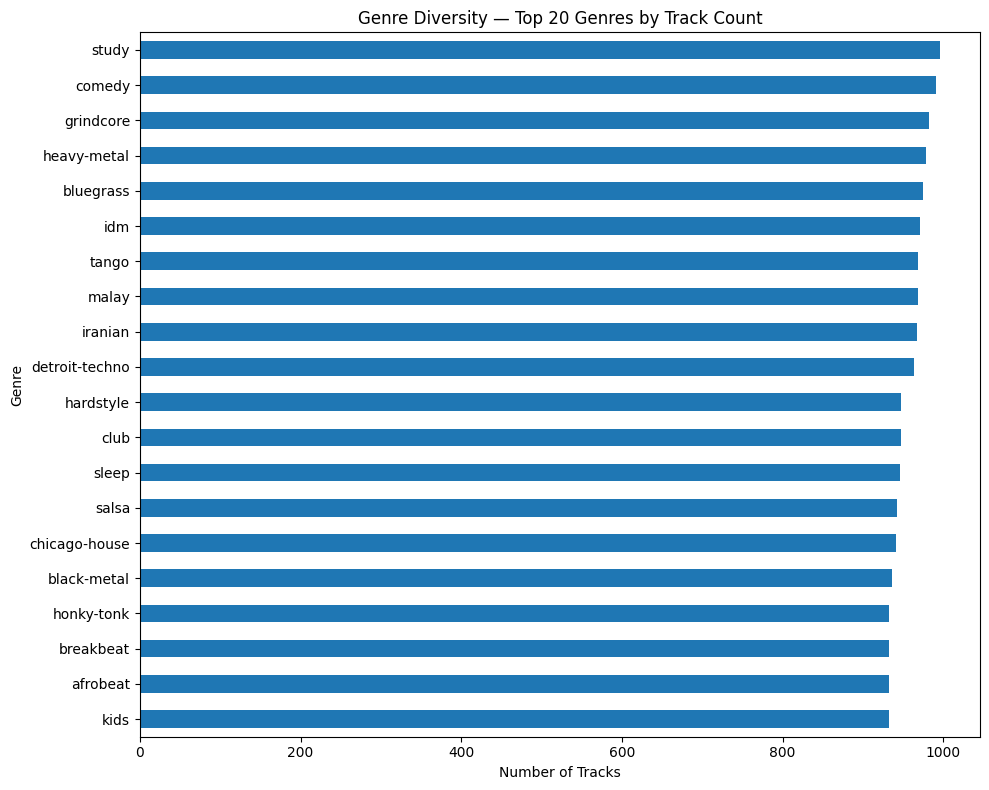

In [56]:
import matplotlib.pyplot as plt
#SAVE_FIGS = False  # set True to save PNGs in reports/figures
#FIG_DIR = "reports/figures"
TOP_N_GENRES = 20
TOP_N_ARTISTS = 20
MIN_TRACKS_FOR_AVG_POP = 20  # for popularity chart

if "track_genre" in df.columns:
    genre_counts = df["track_genre"].value_counts().head(TOP_N_GENRES).sort_values(ascending=True)

    plt.figure(figsize=(10, 8))
    genre_counts.plot(kind="barh")
    plt.title(f"Genre Diversity — Top {TOP_N_GENRES} Genres by Track Count")
    plt.xlabel("Number of Tracks")
    plt.ylabel("Genre")
    plt.tight_layout()
    #_maybe_save(f"genre_diversity_top_{TOP_N_GENRES}.png")
    plt.show()

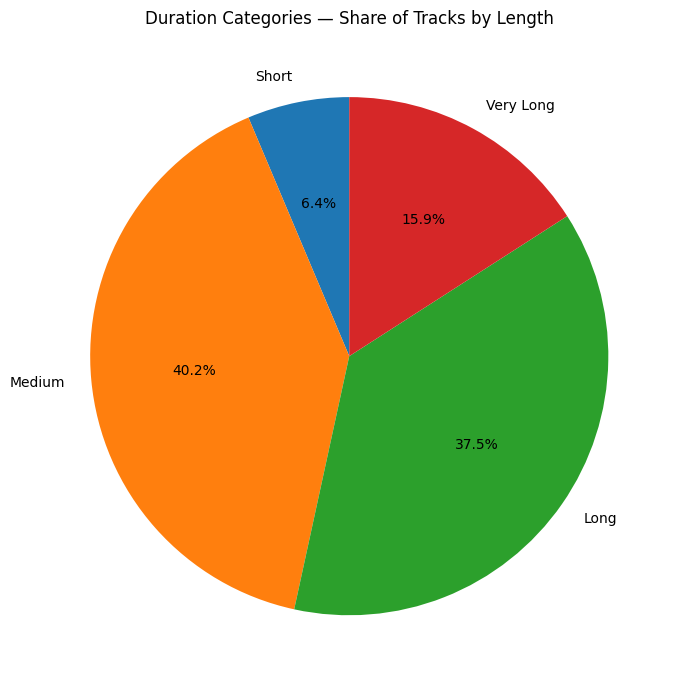

In [64]:
if "duration_ms" in df.columns:
    df["duration_min"] = df["duration_ms"] / 60000.0
    df["duration_bucket"] = pd.cut(
        df["duration_min"],
        bins=[0, 2, 3.5, 5, np.inf],
        labels=["Short", "Medium", "Long", "Very Long"],
        include_lowest=True
    )
plt.figure(figsize=(7, 7))
plt.pie(
    duration_counts,
    labels=duration_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Duration Categories — Share of Tracks by Length")
plt.tight_layout()
plt.show()

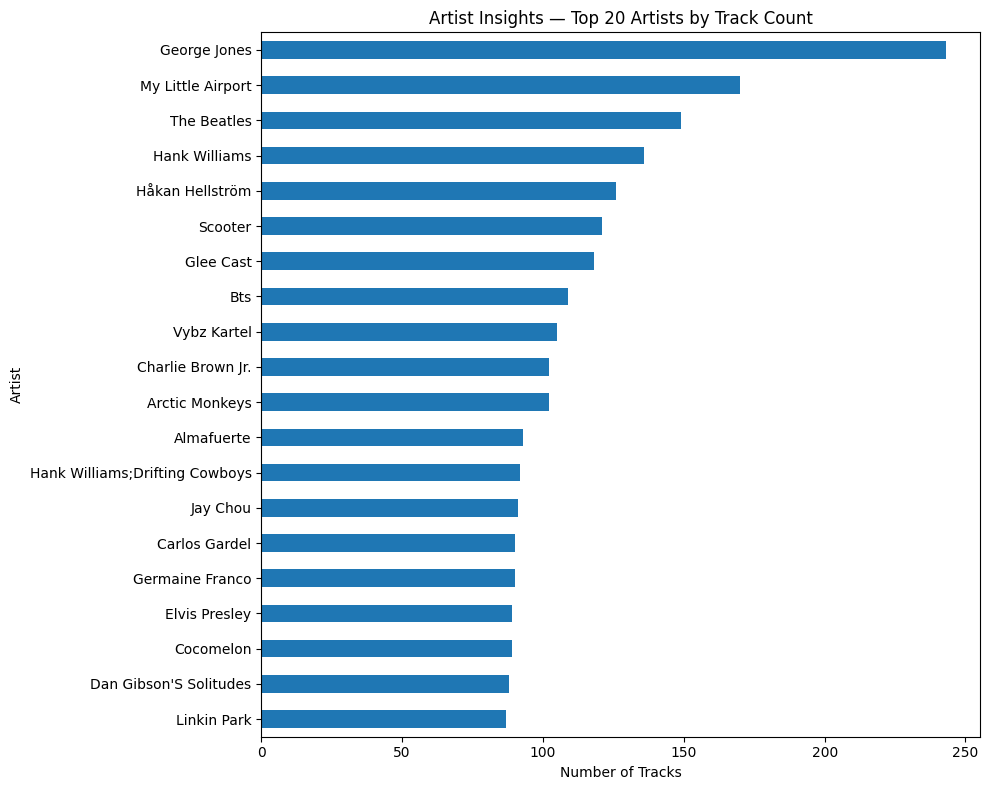

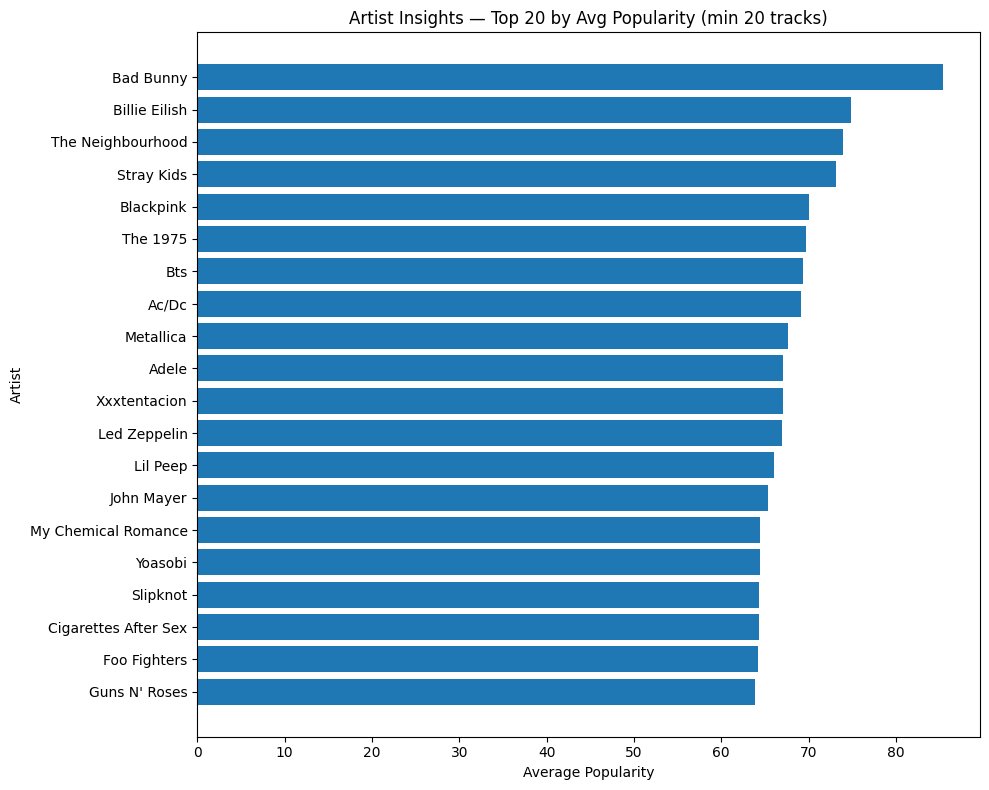

In [62]:
# =========================================================
# 3) Artist Insights
#    A) Top N artists by track count (barh)
#    B) Top artists by average popularity (barh) with minimum tracks filter
# =========================================================
if "artists" in df.columns:
    # A) Top by track count
    top_artist_counts = df["artists"].value_counts().head(TOP_N_ARTISTS).sort_values(ascending=True)

    plt.figure(figsize=(10, 8))
    top_artist_counts.plot(kind="barh")
    plt.title(f"Artist Insights — Top {TOP_N_ARTISTS} Artists by Track Count")
    plt.xlabel("Number of Tracks")
    plt.ylabel("Artist")
    plt.tight_layout()
    #_maybe_save(f"artist_top_{TOP_N_ARTISTS}_by_count.png")
    plt.show()

    # B) Top by average popularity (min tracks)
    if "popularity" in df.columns:
        grp = (df.groupby("artists", as_index=False)
                 .agg(track_count=("artists","size"),
                      avg_popularity=("popularity","mean")))
        filt = (grp[grp["track_count"] >= MIN_TRACKS_FOR_AVG_POP]
                    .sort_values("avg_popularity", ascending=False)
                    .head(TOP_N_ARTISTS)
                    .sort_values("avg_popularity"))

        plt.figure(figsize=(10, 8))
        plt.barh(filt["artists"], filt["avg_popularity"])
        plt.title(f"Artist Insights — Top {TOP_N_ARTISTS} by Avg Popularity (min {MIN_TRACKS_FOR_AVG_POP} tracks)")
        plt.xlabel("Average Popularity")
        plt.ylabel("Artist")
        plt.tight_layout()
        #_maybe_save(f"artist_top_{TOP_N_ARTISTS}_by_avg_pop_min_{MIN_TRACKS_FOR_AVG_POP}.png")
        plt.show()